In [2]:
import pandas as pd

# 파일 경로
file1 = 'df_energy_solar.csv'
file2 = 'df_energy_solar2.csv'

# 데이터 불러오기
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# 데이터 결합
df_merged = pd.concat([df1, df2], ignore_index=True)

# 결과 저장 (선택)
df_merged.to_csv('df_energy_solar+solar2.csv', index=False)

# 결합된 데이터 확인
print(df_merged.shape)
print(df_merged.head())


(205632, 6)
           일자         발전구분  설비용량(MW)  시간  발전량(kWh)  연식(년)
0  2023-01-01  (군산)영암F1태양광    13.296   1       0.0   10.1
1  2023-01-02  (군산)영암F1태양광    13.296   1       0.0   10.1
2  2023-01-03  (군산)영암F1태양광    13.296   1       0.0   10.1
3  2023-01-04  (군산)영암F1태양광    13.296   1       0.0   10.1
4  2023-01-05  (군산)영암F1태양광    13.296   1       0.0   10.1


C:\Users\박경국\AppData\Local\Temp\ipykernel_65752\2621843618.py:30: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  plt.tight_layout()
C:\Users\박경국\AppData\Local\Temp\ipykernel_65752\2621843618.py:30: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  plt.tight_layout()
C:\Users\박경국\AppData\Local\Temp\ipykernel_65752\2621843618.py:30: UserWarning: Glyph 48156 (\N{HANGUL SYLLABLE BAL}) missing from current font.
  plt.tight_layout()
C:\Users\박경국\AppData\Local\Temp\ipykernel_65752\2621843618.py:30: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  plt.tight_layout()
C:\Users\박경국\AppData\Local\Temp\ipykernel_65752\2621843618.py:30: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  plt.tight_layout()
C:\Users\박경국\AppData\Local\Temp\ipykernel_65752\2621843618.py:30: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  plt.tight_layout()
C:\User

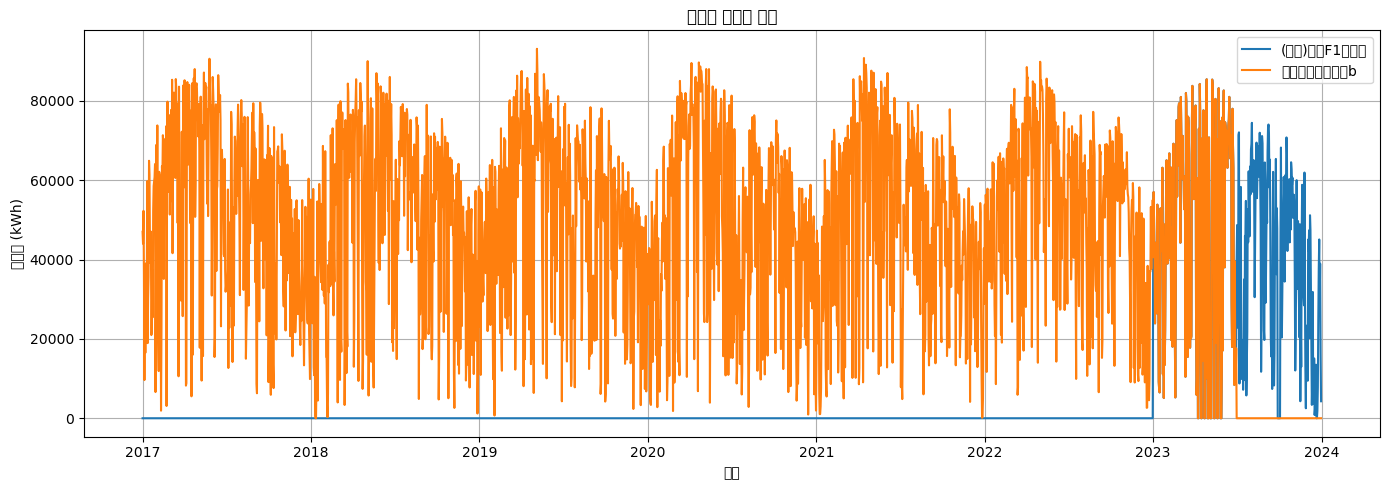

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# 발전소 이름 설정
plant_a = '(군산)영암F1태양광'
plant_b = '영암에프원태양광b'

# 두 발전소 필터링
df_compare = df_merged[df_merged['발전구분'].isin([plant_a, plant_b])]

# 일자별 발전량 합계 계산
df_grouped = df_compare.groupby(['발전구분', '일자'])['발전량(kWh)'].sum().reset_index()

# 피벗 테이블로 변환: 행 = 일자, 열 = 발전소
df_pivot = df_grouped.pivot(index='일자', columns='발전구분', values='발전량(kWh)').fillna(0)

# 일자 문자열을 datetime 형식으로 변환
df_pivot.index = pd.to_datetime(df_pivot.index, errors='coerce')
df_pivot = df_pivot.sort_index()

# 그래프 그리기
plt.figure(figsize=(14, 5))
plt.plot(df_pivot.index, df_pivot[plant_a], label=plant_a)
plt.plot(df_pivot.index, df_pivot[plant_b], label=plant_b)
plt.title('일자별 발전량 비교')
plt.xlabel('일자')
plt.ylabel('발전량 (kWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\박경국\AppData\Local\Temp\ipykernel_65752\3302730110.py:32: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  plt.tight_layout()
C:\Users\박경국\AppData\Local\Temp\ipykernel_65752\3302730110.py:32: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  plt.tight_layout()
C:\Users\박경국\AppData\Local\Temp\ipykernel_65752\3302730110.py:32: UserWarning: Glyph 48156 (\N{HANGUL SYLLABLE BAL}) missing from current font.
  plt.tight_layout()
C:\Users\박경국\AppData\Local\Temp\ipykernel_65752\3302730110.py:32: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  plt.tight_layout()
C:\Users\박경국\AppData\Local\Temp\ipykernel_65752\3302730110.py:32: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  plt.tight_layout()
C:\Users\박경국\AppData\Local\Temp\ipykernel_65752\3302730110.py:32: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from current font.
  plt.tight_layout()
C:\User

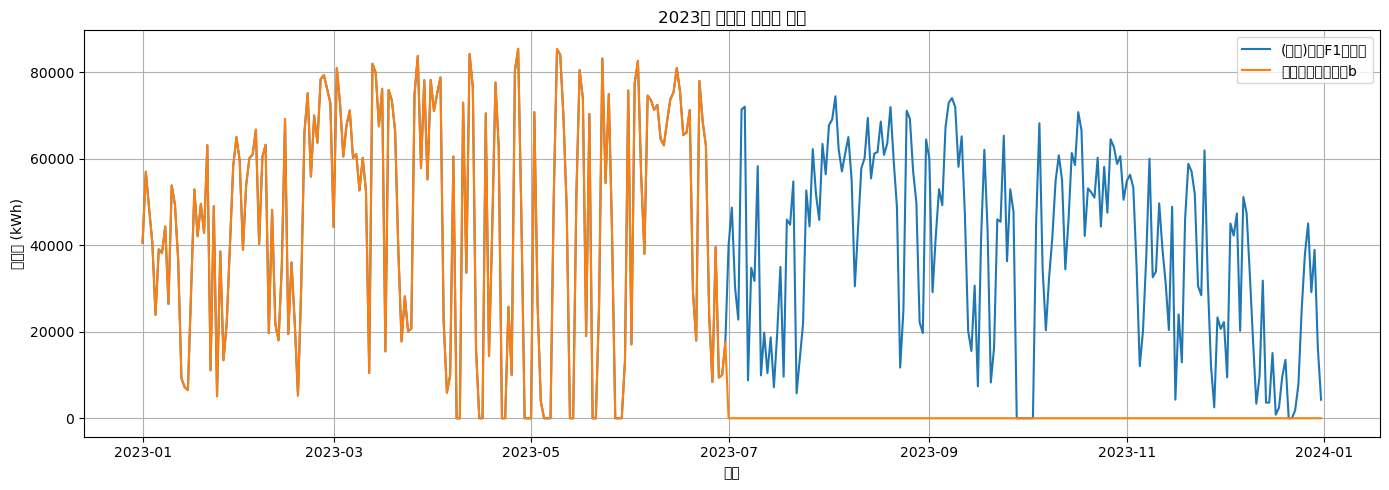

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# 발전소 이름
plant_a = '(군산)영암F1태양광'
plant_b = '영암에프원태양광b'

# '일자'를 datetime으로 변환 (필요 시)
df_merged['일자'] = pd.to_datetime(df_merged['일자'], errors='coerce')

# 2023년 데이터만 필터링
df_2023 = df_merged[df_merged['일자'].dt.year == 2023]

# 비교 대상 발전소 필터링
df_compare = df_2023[df_2023['발전구분'].isin([plant_a, plant_b])]

# 일자별 발전량 합계
df_grouped = df_compare.groupby(['발전구분', '일자'])['발전량(kWh)'].sum().reset_index()

# 피벗 테이블 변환
df_pivot = df_grouped.pivot(index='일자', columns='발전구분', values='발전량(kWh)').fillna(0)

# 그래프 출력
plt.figure(figsize=(14, 5))
plt.plot(df_pivot.index, df_pivot[plant_a], label=plant_a)
plt.plot(df_pivot.index, df_pivot[plant_b], label=plant_b)
plt.title('2023년 일자별 발전량 비교')
plt.xlabel('일자')
plt.ylabel('발전량 (kWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
import pandas as pd
import numpy as np

# 발전소 이름
plant_a = '(군산)영암F1태양광'
plant_b = '영암에프원태양광b'

# '일자'를 datetime으로 변환
df_merged['일자'] = pd.to_datetime(df_merged['일자'], errors='coerce')

# 2023년 데이터만 추출
df_2023 = df_merged[df_merged['일자'].dt.year == 2023]

# 두 발전소만 필터링
df_two = df_2023[df_2023['발전구분'].isin([plant_a, plant_b])]

# 일자별 발전량 집계
df_grouped = df_two.groupby(['발전구분', '일자'])['발전량(kWh)'].sum().reset_index()

# 피벗: 일자별로 두 발전소의 발전량 비교 가능하도록
df_pivot = df_grouped.pivot(index='일자', columns='발전구분', values='발전량(kWh)').dropna()

# 차이율 계산
df_pivot['차이율'] = np.abs(df_pivot[plant_a] - df_pivot[plant_b]) / df_pivot[[plant_a, plant_b]].max(axis=1)

# 연-월 컬럼 생성
df_pivot['연월'] = df_pivot.index.to_period('M')

# 월별 1% 이하 차이율 비율 계산
df_result = (
    df_pivot.groupby('연월')['차이율']
    .apply(lambda x: (x <= 0.01).mean() * 100)
    .reset_index(name='일치율(%)')
)

# 결과 출력
print(df_result)


        연월      일치율(%)
0  2023-01  100.000000
1  2023-02  100.000000
2  2023-03  100.000000
3  2023-04   73.333333
4  2023-05   64.516129
5  2023-06  100.000000


In [21]:
# 발전소 이름
plant_a = '(군산)영암F1태양광'
plant_b = '영암에프원태양광b'

# '일자' datetime 변환
df_merged['일자'] = pd.to_datetime(df_merged['일자'], errors='coerce')

# 1~6월 필터링
df_filtered = df_merged[
    (df_merged['일자'].dt.year == 2023) &
    (df_merged['일자'].dt.month <= 6) &
    (df_merged['발전구분'].isin([plant_a, plant_b]))
]

# 일자별 발전량 합계
df_daily = df_filtered.groupby(['일자', '발전구분'])['발전량(kWh)'].sum().reset_index()

# 피벗 테이블로 변환
df_pivot = df_daily.pivot(index='일자', columns='발전구분', values='발전량(kWh)').fillna(0)

# 보기 좋게 출력
print(df_pivot.head(30))  # 상위 30일만 예시로 출력



발전구분        (군산)영암F1태양광  영암에프원태양광b
일자                                
2023-01-01      40588.8    40588.8
2023-01-02      57024.0    57024.0
2023-01-03      48672.0    48672.0
2023-01-04      40742.4    40742.4
2023-01-05      23913.6    23913.6
2023-01-06      39072.0    39072.0
2023-01-07      38198.4    38198.4
2023-01-08      44352.0    44352.0
2023-01-09      26428.8    26428.8
2023-01-10      53836.8    53836.8
2023-01-11      49392.0    49392.0
2023-01-12      36480.0    36480.0
2023-01-13       9225.6     9225.6
2023-01-14       7200.0     7200.0
2023-01-15       6508.8     6508.8
2023-01-16      29539.2    29539.2
2023-01-17      52905.6    52905.6
2023-01-18      42105.6    42105.6
2023-01-19      49584.0    49584.0
2023-01-20      42883.2    42883.2
2023-01-21      63148.8    63148.8
2023-01-22      11088.0    11088.0
2023-01-23      49046.4    49046.4
2023-01-24       5097.6     5097.6
2023-01-25      38572.8    38572.8
2023-01-26      13420.8    13420.8
2023-01-27      2213

In [22]:
import pandas as pd

# 발전소 이름
plant_a = '(군산)영암F1태양광'
plant_b = '영암에프원태양광b'

# 일자 형식 변환
df_merged['일자'] = pd.to_datetime(df_merged['일자'], errors='coerce')

# 2023년 1~6월 필터링
df_filtered = df_merged[
    (df_merged['일자'].dt.year == 2023) &
    (df_merged['일자'].dt.month <= 6) &
    (df_merged['발전구분'].isin([plant_a, plant_b]))
]

# 일자별 발전량 집계
df_daily = df_filtered.groupby(['일자', '발전구분'])['발전량(kWh)'].sum().reset_index()

# 피벗 테이블로 변환
df_pivot = df_daily.pivot(index='일자', columns='발전구분', values='발전량(kWh)').fillna(0)

# CSV로 저장
df_pivot.to_csv("2023_1to6_solar_generation.csv", encoding='utf-8-sig')

print("✅ 저장 완료: 2023_1to6_solar_generation.csv")


✅ 저장 완료: 2023_1to6_solar_generation.csv
